<a href="https://colab.research.google.com/github/baraa-hakawati/Chicago-Crime-Analysis/blob/main/Chicago_Crime_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chicago Crime Analysis**

In [ ]:
# Importing needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose
import glob
#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
## Setting figures to timeseries-friendly
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
# set random seed
SEED = 321
np.random.seed(SEED)
#display more columns
pd.set_option('display.max_columns',50)

In [ ]:
# Reading the whole csv files
path = '/content/drive/MyDrive/AXSOSACADEMY/04-DataViz/Week15/Data/Data/*.csv'  # Reads all CSVs in the folder
all_files = glob.glob(path)
# Read and combine into one DataFrame
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [ ]:
# Viewing the data content
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7713109 entries, 0 to 7713108
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 603.2+ MB


,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Testing
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7713109 entries, 0 to 7713108
Data columns (total 12 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Date                  datetime64[ns]
 2   Primary Type          object        
 3   Description           object        
 4   Location Description  object        
 5   Arrest                bool          
 6   Domestic              bool          
 7   Beat                  int64         
 8   District              float64       
 9   Ward                  float64       
 10  Latitude              float64       
 11  Longitude             float64       
dtypes: bool(2), datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 603.2+ MB


,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,2001-01-01 01:00:00,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,2001-01-01 13:00:00,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,2001-01-01 13:00:00,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,2001-01-01 01:00:00,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,2001-01-01 01:00:00,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020


In [ ]:
# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [ ]:
# Adding new columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.date
df['hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.day_name()

In [ ]:
# Convert the date to datetime and set as index
df = df.set_index('date')

In [ ]:
# Normalized missing values summary
missing_summary = df.isna().sum()
missing_percent = (missing_summary / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing %': missing_percent.round(2)
}).sort_values(by='Missing %', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

                      Missing Count  Missing %
ward                         614846       7.97
latitude                      88685       1.15
longitude                     88685       1.15
location_description          10928       0.14
district                         47       0.00


In [ ]:
# Drop rows missing lat/lon only if spatial analysis is needed
df = df.dropna(subset=['latitude', 'longitude'])
# Fill missing location descriptions with 'UNKNOWN'
df['location_description'] = df['location_description'].fillna('UNKNOWN')
# Fill missing districts using backward then forward fill (since only 47 missing)
df['district'] = df['district'].bfill()
df['district'] = df['district'].ffill()

In [ ]:
# Daily counts
daily_crime = df.resample("D").size()

In [ ]:
# Topic 1: Police Districts
district_crime = df[df['year'] == 2022].groupby('district').size().sort_values(ascending=False)
most_crime_district = district_crime.idxmax()
least_crime_district = district_crime.idxmin()
print(f"District with most crimes in 2022: {most_crime_district} ({district_crime.max()} crimes)")
print(f"District with least crimes in 2022: {least_crime_district} ({district_crime.min()} crimes)")

District with most crimes in 2022: 8.0 (14512 crimes)
District with least crimes in 2022: 31.0 (15 crimes)


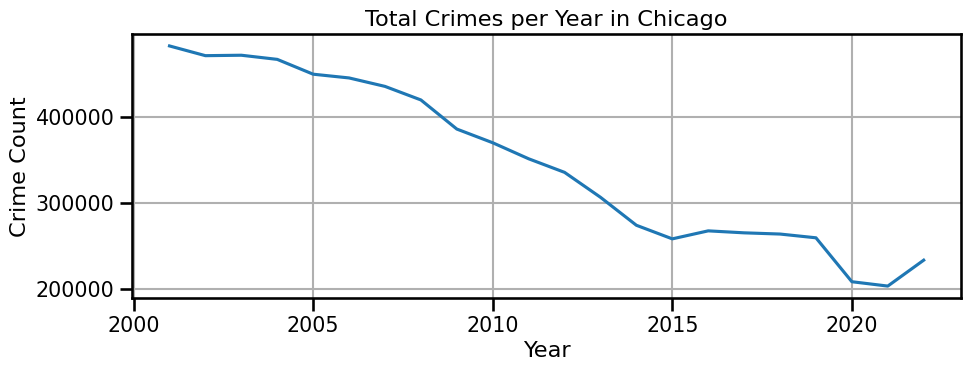

In [ ]:
# Topic 2: Crimes Across Years
crime_by_year = df.groupby('year').size()
plt.figure(figsize=(10,4))
sns.lineplot(x=crime_by_year.index, y=crime_by_year.values)
plt.title("Total Crimes per Year in Chicago")
plt.xlabel("Year"); plt.ylabel("Crime Count")
plt.grid(); plt.tight_layout(); plt.show()

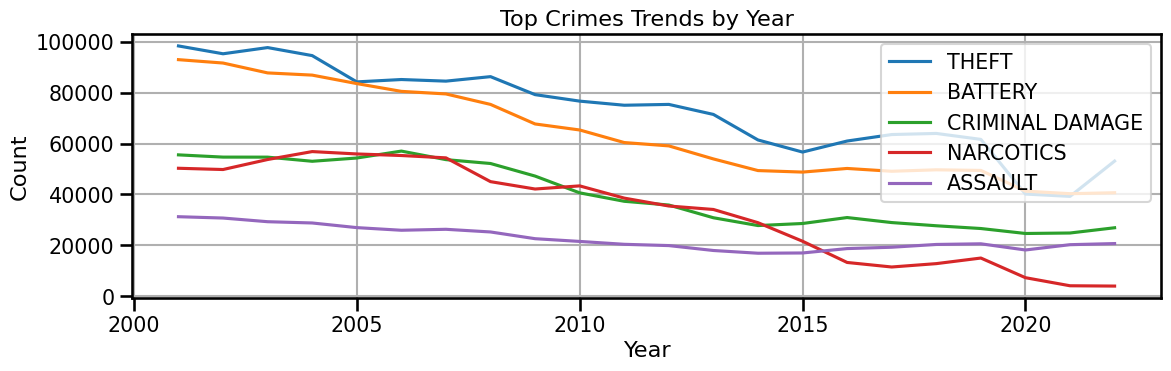

In [ ]:
# Check individual crime trends
top_crimes = df['primary_type'].value_counts().head(5).index
for crime in top_crimes:
    sub = df[df['primary_type'] == crime].groupby('year').size()
    plt.plot(sub.index, sub.values, label=crime)
plt.legend(); plt.title("Top Crimes Trends by Year"); plt.xlabel("Year"); plt.ylabel("Count")
plt.grid(); plt.tight_layout(); plt.show()

In [ ]:
# Topic 3: AM vs PM Rush Hour
am = df[(df['hour'] >= 7) & (df['hour'] < 10)]
pm = df[(df['hour'] >= 16) & (df['hour'] < 19)]
print(f"\nAM crimes: {len(am)}")
print(f"PM crimes: {len(pm)}")


AM crimes: 757433
PM crimes: 1196418


In [ ]:
top_am = am['primary_type'].value_counts().head(5)
top_pm = pm['primary_type'].value_counts().head(5)
print("\nTop 5 AM Crimes:\n", top_am)
print("\nTop 5 PM Crimes:\n", top_pm)


Top 5 AM Crimes:
 primary_type
THEFT              181589
BATTERY            107747
CRIMINAL DAMAGE     80806
BURGLARY            73712
OTHER OFFENSE       61709
Name: count, dtype: int64

Top 5 PM Crimes:
 primary_type
THEFT              290853
BATTERY            212082
CRIMINAL DAMAGE    133427
NARCOTICS          101289
ASSAULT             89230
Name: count, dtype: int64


In [ ]:
motor_am = am[am['primary_type'] == "MOTOR VEHICLE THEFT"].shape[0]
motor_pm = pm[pm['primary_type'] == "MOTOR VEHICLE THEFT"].shape[0]
print(f"\nMotor Vehicle Theft: AM = {motor_am}, PM = {motor_pm}")


Motor Vehicle Theft: AM = 41147, PM = 53213


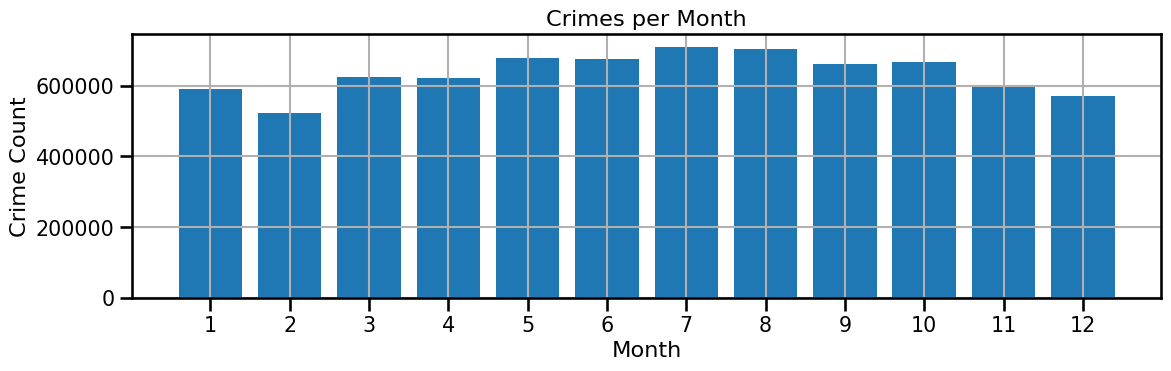

In [ ]:
# Topic 4: Monthly Patterns
month_counts = df.groupby('month').size()
plt.bar(month_counts.index, month_counts.values)
plt.title("Crimes per Month"); plt.xlabel("Month"); plt.ylabel("Crime Count")
plt.xticks(range(1,13)); plt.grid(True); plt.tight_layout(); plt.show()

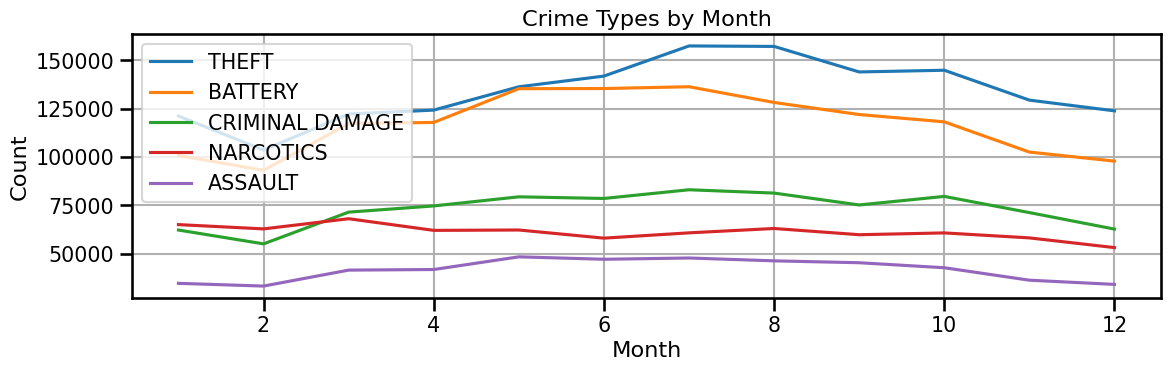

In [ ]:
# Individual crime trends by month
for crime in top_crimes:
    month_trend = df[df['primary_type'] == crime].groupby('month').size()
    plt.plot(month_trend.index, month_trend.values, label=crime)
plt.legend(); plt.title("Crime Types by Month"); plt.xlabel("Month"); plt.ylabel("Count")
plt.grid(); plt.tight_layout(); plt.show()

In [ ]:
# Topic 5: Crimes on Holidays
us_holidays = holidays.US(years=df['year'].unique())
df['is_holiday'] = [date in us_holidays for date in df.index.date]
holiday_crimes = df[df['is_holiday']]
holiday_names = pd.Series([us_holidays.get(date, "Unknown") for date in holiday_crimes.index.date])
top_holidays = holiday_names.value_counts().head(3)
print("\nTop 3 Holidays with most crimes:\n", top_holidays)


Top 3 Holidays with most crimes:
 New Year's Day      28356
Independence Day    22508
Labor Day           21850
Name: count, dtype: int64


In [ ]:
# Top 5 crime types on each top holiday
for name in top_holidays.index:
    dates = [k for k, v in us_holidays.items() if v == name]
    # Convert the list of dates to a pandas DatetimeIndex for correct filtering
    holiday_dates = pd.DatetimeIndex(dates)
    crimes_on = df[df.index.isin(holiday_dates)]
    print(f"\n{name} - Top 5 crimes:\n", crimes_on['primary_type'].value_counts().head(5))


New Year's Day - Top 5 crimes:
 primary_type
THEFT                         703
OFFENSE INVOLVING CHILDREN    410
DECEPTIVE PRACTICE            274
OTHER OFFENSE                 251
CRIMINAL DAMAGE               157
Name: count, dtype: int64

Independence Day - Top 5 crimes:
 primary_type
CRIMINAL DAMAGE        115
THEFT                  112
DECEPTIVE PRACTICE      34
OTHER OFFENSE           34
MOTOR VEHICLE THEFT     33
Name: count, dtype: int64

Labor Day - Top 5 crimes:
 primary_type
THEFT                  161
CRIMINAL DAMAGE         88
OTHER OFFENSE           51
DECEPTIVE PRACTICE      44
MOTOR VEHICLE THEFT     38
Name: count, dtype: int64


/tmp/ipython-input-51-3854506624.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = df.resample("M").size()


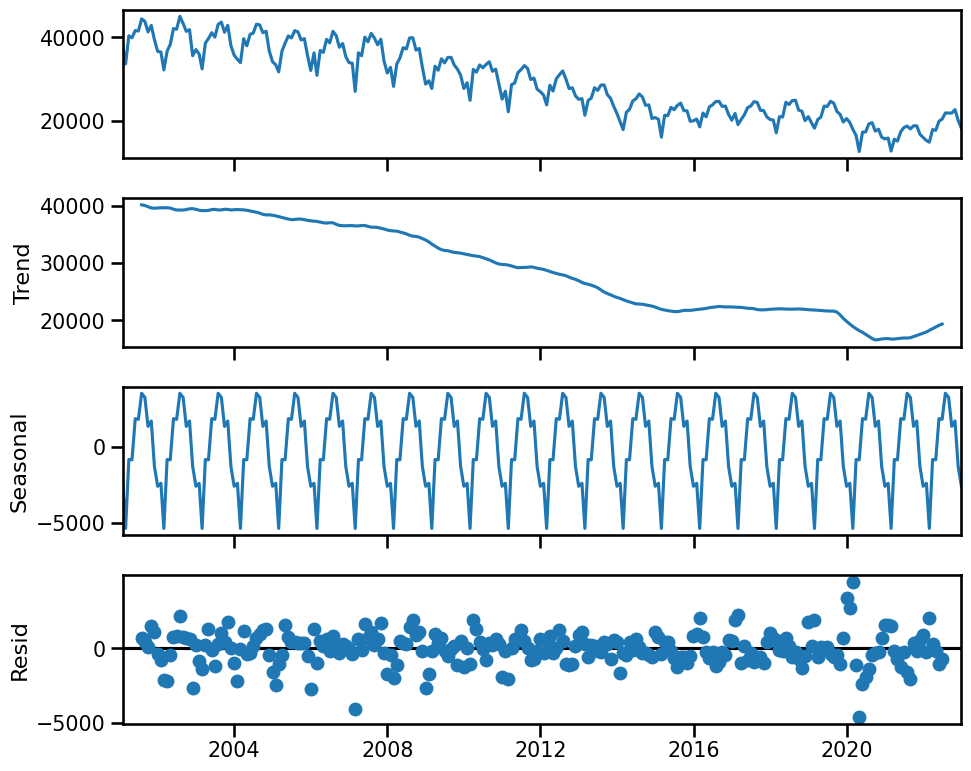

In [ ]:
# Topic 6: Seasonality Detection
monthly_series = df.resample("M").size()
result = seasonal_decompose(monthly_series, model="additive")
fig = result.plot()
fig.set_size_inches(10,8)
fig.tight_layout()

In [ ]:
cycle_magnitude = monthly_series.max() - monthly_series.min()
print(f"\nApproximate cycle length: 12 months")
print(f"Cycle magnitude (Max - Min): {cycle_magnitude}")


Approximate cycle length: 12 months
Cycle magnitude (Max - Min): 32254
